In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2023-12-28 14:15:22.257217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 14:15:22.257249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 14:15:22.258277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 14:15:22.264238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 14:15:23.157416: W tensorflow/compiler/tf2

In [2]:
dataframe = pd.read_csv('../scripting/ecg_downloader/data/merged_ecg_data.csv')
transposed_dataframe = dataframe.transpose()
raw_data = transposed_dataframe.values
transposed_dataframe.head

<bound method NDFrame.head of      0         1         2         3         4         5         6        \
ECG  0.89936  0.830238  0.780865  0.751242  0.741367  0.701869  0.672245   

     7         8         9        ...   1499990   1499991   1499992   1499993  \
ECG  0.68212  0.662371  0.642621  ...  0.010649  0.010649  0.010649  0.010649   

      1499994   1499995   1499996   1499997   1499998   1499999  
ECG  0.010649  0.010649  0.020523  0.050147  0.060022  0.079771  

[1 rows x 1500000 columns]>

In [3]:
subjects_reshaped = transposed_dataframe.values.reshape((250, 6000))
subjects_reshaped.shape

(250, 6000)

In [4]:
first_200_points = subjects_reshaped[:, :200]
#first_100_points = subjects_reshaped
first_200_points.shape

(250, 200)

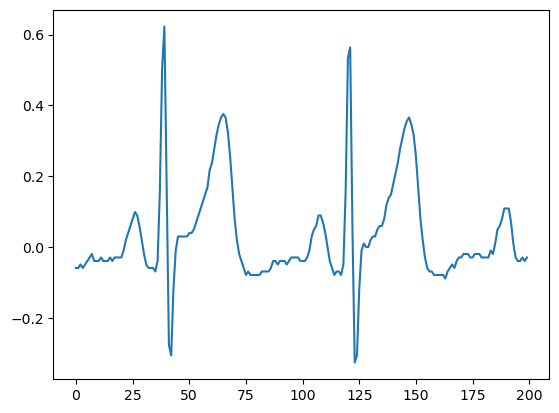

In [5]:
plt.plot(first_200_points[14])

In [6]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(200, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

2023-12-28 14:15:24.743095: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-28 14:15:24.743152: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: 033b258647f7
2023-12-28 14:15:24.743158: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: 033b258647f7
2023-12-28 14:15:24.743277: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 515.105.1
2023-12-28 14:15:24.743298: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-28 14:15:24.743303: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 515.105.1 -- cannot find working devices in this configuration


In [7]:
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
history = autoencoder.fit(first_200_points, first_200_points, 
          epochs=4000, 
          batch_size=32,
          shuffle=True)

Epoch 1/4000
8/8 [==============================] - 1s 2ms/step - loss: 0.5039
Epoch 2/4000
8/8 [==============================] - 0s 2ms/step - loss: 0.5003
Epoch 3/4000
8/8 [==============================] - 0s 2ms/step - loss: 0.4955
Epoch 4/4000
8/8 [==============================] - 0s 2ms/step - loss: 0.4860
Epoch 5/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.4705
Epoch 6/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.4471
Epoch 7/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.4189
Epoch 8/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.3901
Epoch 9/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.3597
Epoch 10/4000
8/8 [==============================] - 0s 4ms/step - loss: 0.3332
Epoch 11/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.3105
Epoch 12/4000
8/8 [==============================] - 0s 3ms/step - loss: 0.2967
Epoch 13/4000
8/8 [==============================

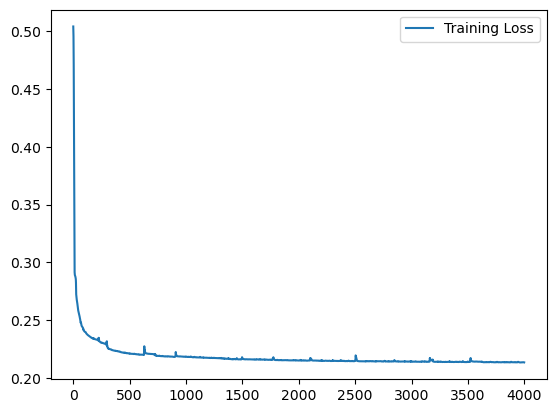

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [10]:
encoded_data = autoencoder.encoder(first_200_points).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

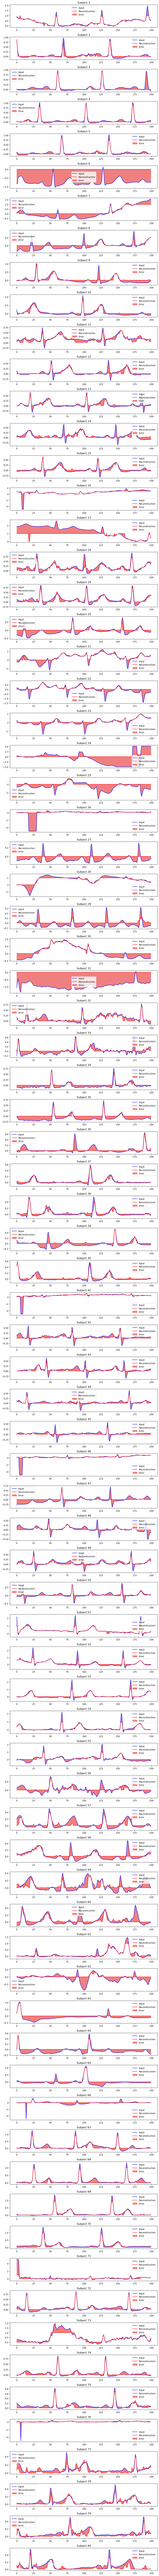

In [11]:
num_subjects = 80

fig, axes = plt.subplots(num_subjects, 1, figsize=(10, 2*num_subjects))

for i in range(num_subjects):
    axes[i].plot(first_200_points[i], 'b')
    axes[i].plot(decoded_data[i], 'r')
    axes[i].fill_between(np.arange(200), decoded_data[i], first_200_points[i], color='lightcoral')
    axes[i].legend(labels=["Input", "Reconstruction", "Error"])
    axes[i].set_title(f'Subject {i+1}')

plt.tight_layout()
plt.show()

8/8 [==============================] - 0s 1ms/step


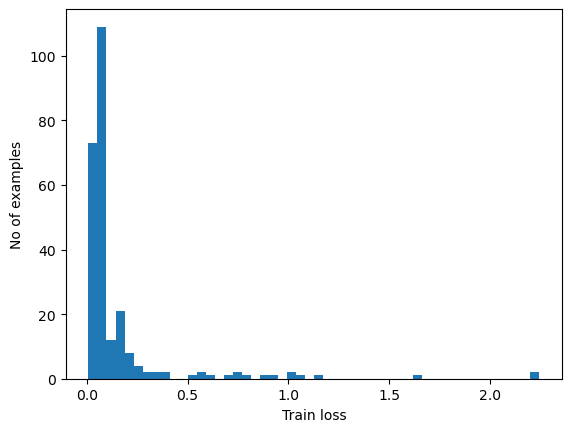

In [12]:
reconstructions = autoencoder.predict(first_200_points)
train_loss = tf.keras.losses.mae(reconstructions, first_200_points)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [13]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.4280151439845882
